## Miniproject 2: MovieLens Visualization



### Download data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd

In [2]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [3]:
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# need to create Y_train and Y_test with correct format for our learning
Y_train = train.to_numpy().astype(int)
Y_test = test.to_numpy().astype(int)

# First Matrix Factorization Method

In [4]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    grad = reg * Ui - Vj * (Yij - np.matmul(Ui, Vj))
    return grad * eta

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    grad = reg * Vj - Ui * (Yij - np.matmul(Ui, Vj))
    return grad * eta

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = reg * (np.linalg.norm(U, ord='fro') ** 2 + np.linalg.norm(V, ord='fro') ** 2) / 2
    for i, j, Y_ij in Y:
      err +=  0.5 * (Y_ij - np.matmul(U[i - 1], V[j- 1])) ** 2
    return err / len(Y)


def train_model(M, N, K, eta, reg, Y_train, Y_test, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    global_bias = np.mean([y_ij for _, _, y_ij in Y_train])
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    errors = []
    errors.append(get_err(U, V, Y_train, reg=reg))
    initial_loss_reduction = 0

    for epoch in range(max_epochs):
      shuffle = np.random.permutation(len(Y_train))
      for idx in shuffle:
        i, j, Y_ij = Y_train[idx]
        U[i - 1] -= grad_U(U[i - 1], Y_ij, V[j - 1], reg, eta)
        V[j - 1] -= grad_V(V[j - 1], Y_ij, U[i - 1], reg, eta)
      errors.append(get_err(U, V, Y_test, reg=reg))
      if epoch == 0:
        initial_loss_reduction = errors[0] - errors[1]
      elif (errors[epoch] - errors[epoch + 1]) / initial_loss_reduction  < eps:
        break
    return (U, V, errors[-1])

In [ ]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

print("Factorizing with ", M, " users, ", N, " movies.")
# grid search for best hyperparameters:
K = 20
max_epochs = [300]
regs = [0.0, 0.001, 0.01, 0.1]
etas = [0.01, 0.05, 0.1] # learning rate
E_in = []
E_out = []

E_in_regs = []
E_out_regs = []

E_in_etas = [[0]* 4] * 3
E_out_etas = [[0]* 4] * 3

hypeparam_scores = {}

iterations = 0

for epochs in max_epochs:
  for i in range(len(regs)):
    reg = regs[i]
    for j in range(len(etas)):
      eta = etas[j]
      U,V, err = train_model(M, N, K, eta, reg, Y_train, Y_test, epochs)
      E_in.append(err)
      test_err = get_err(U, V, Y_test)
      E_out.append(test_err)
      hypeparam_scores[(epochs, reg, eta)] = test_err
      print(iterations)
      iterations += 1
top_five = sorted(list(hypeparam_scores.items()), key=lambda item: item[1])[:5]
print("format: (max_epochs, reg, eta)")
print("The best hyperparameters are:")
top_five

Factorizing with  943  users,  1682  movies.
0
1
2
3
4
5
6
7
8
9
10
11
format: (max_epochs, reg, eta)
The best hyperparameters are:


[((300, 0.1, 0.05), 0.5213191189905491),
 ((300, 0.1, 0.1), 0.5848679059002322),
 ((300, 0.01, 0.05), 0.629809956351322),
 ((300, 0.0, 0.01), 0.7003846934951454),
 ((300, 0.001, 0.01), 0.7013189384336496)]

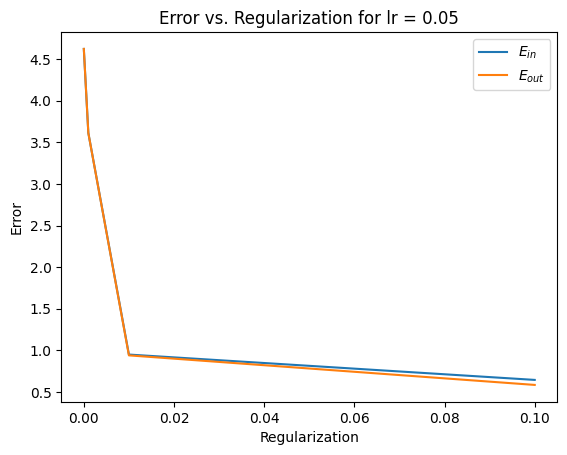

In [ ]:
# now will plot how error changes based on the regularization value
# assuming a learning rate of 0.05 as that is the best value
num_tested = len(regs)*len(etas)*len(max_epochs)
plt.plot(regs, E_in[2:num_tested:len(etas)], label='$E_{in}$')
plt.plot(regs, E_out[2:num_tested:len(etas)], label='$E_{out}$')
plt.title('Error vs. Regularization for lr = 0.05')
plt.xlabel('Regularization')
plt.ylabel('Error')
plt.legend()

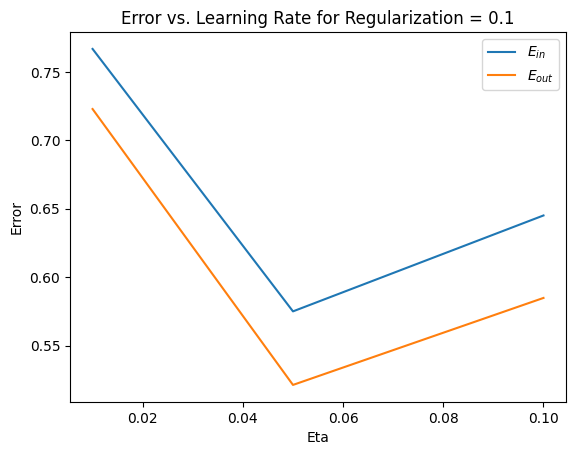

In [ ]:
# now will plot how error changes based on the Learning rate
# this assumes regularization of 0.1, which was the best value
num_tested = len(regs)*len(etas)*len(max_epochs)
plt.plot(etas, E_in[9:12], label='$E_{in}$')
plt.plot(etas, E_out[9:12], label='$E_{out}$')
plt.title('Error vs. Learning Rate for Regularization = 0.1')
plt.xlabel('Eta')
plt.ylabel('Error')
plt.legend()

In [70]:
# best_model = 300 epochs, 0.1 regularization, 0.05 learning rate
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20
U,V, err = train_model(M, N, K, 0.05, 0.1, Y_train, Y_test, max_epochs=300)
err

0.5389870239941318

In [71]:
def get_projections(U, V):
  # have to transpose U and V (because of the way they are defined in out model)
  A, Sigma, B = np.linalg.svd(V.T)
  U_tilde = np.matmul(A[:, :2].T, U.T)
  V_tilde = np.matmul(A[:, :2].T, V.T)
  return U_tilde, V_tilde

In [72]:
def plot_visualizations(movie_ids, plot_title, V_tilde):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    movie_idxs = [id - 1 for id in movie_ids]
    movie_coords = V_tilde[:, movie_idxs]
    movie_titles = np.array(movies['Movie Title'][movie_idxs])

    # normalize movie_coords by subtracting mean so that the data is centered around 0
    movie_coords[0] = movie_coords[0] - np.mean(movie_coords[0])
    movie_coords[1] = movie_coords[1] - np.mean(movie_coords[1])

    plt.scatter(movie_coords[0], movie_coords[1], s=50, c=avg_ratings[movie_idxs], cmap='RdYlGn', norm=plt.Normalize(vmin=0, vmax=5))
    plt.colorbar().set_label("Average Rating")
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    ax.axhline(0, linestyle='--', color='k')
    ax.axvline(0, linestyle='--', color='k')
    plt.title(plot_title)
    for i in range(len(movie_titles)):
        plt.annotate(movie_titles[i], (movie_coords[0][i], movie_coords[1][i]), horizontalalignment='center', verticalalignment='bottom', fontsize=8, xytext=(0, 5), textcoords='offset points')
    plt.show()

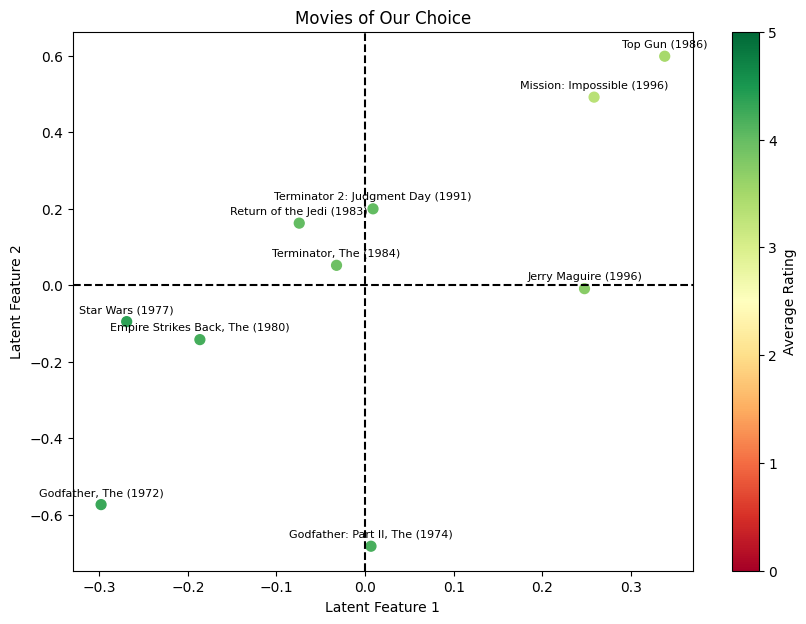

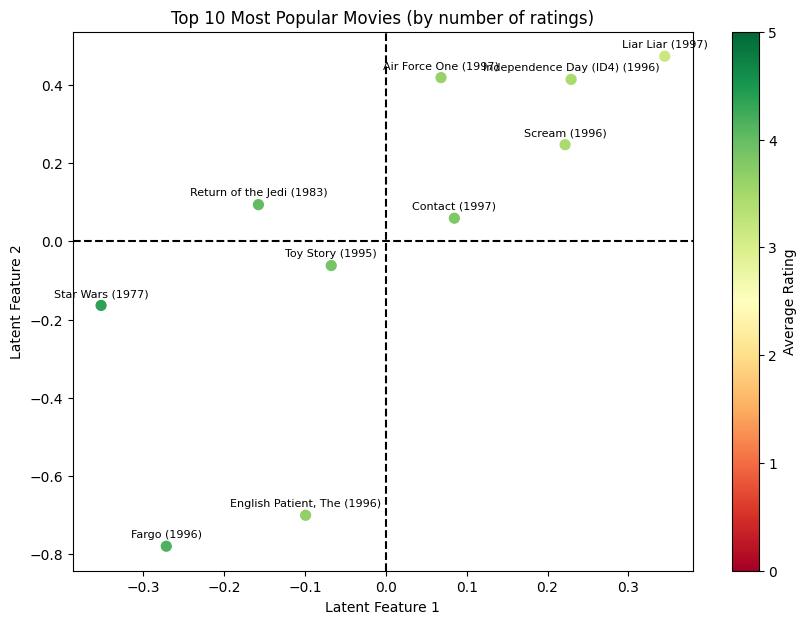

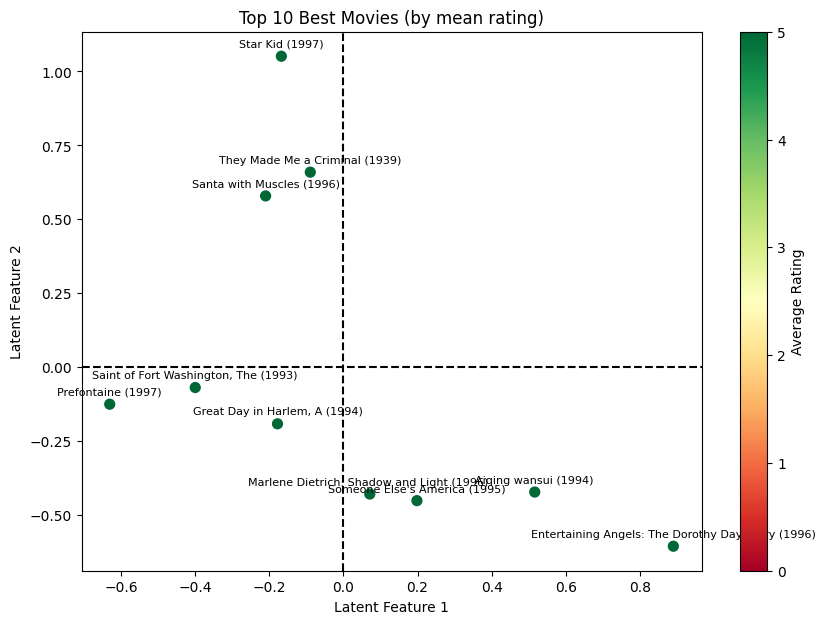

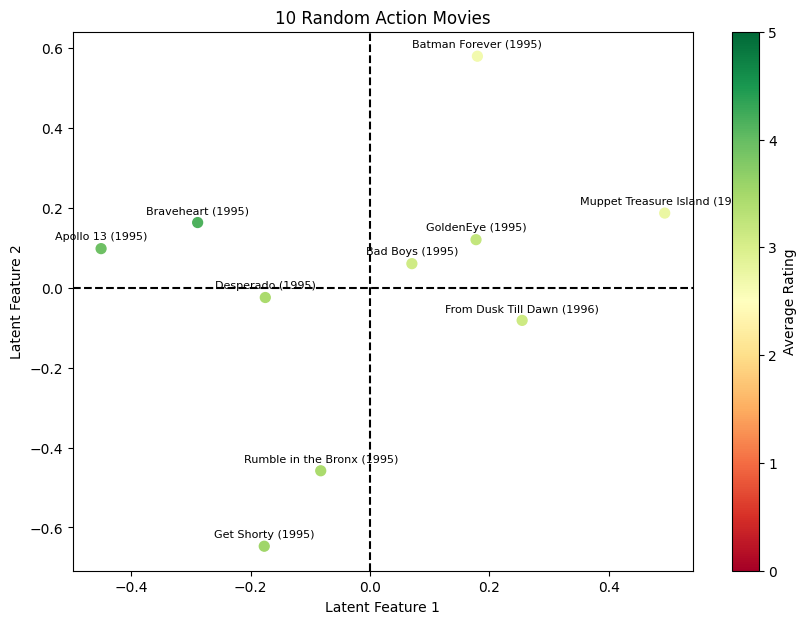

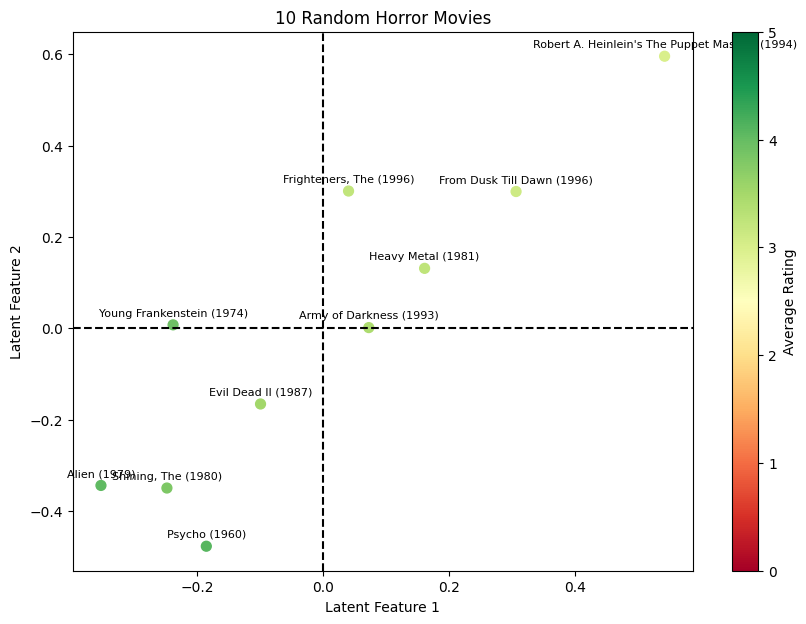

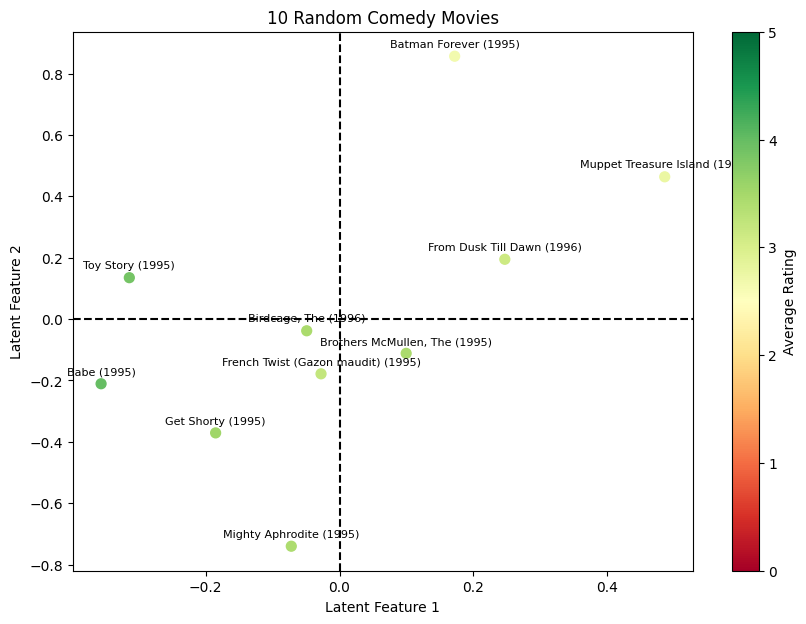

In [73]:
U_tilde, V_tilde = get_projections(U, V)
avg_ratings = np.array(data[['Movie ID', 'Rating']].groupby('Movie ID').mean().sort_values('Movie ID'))

chosen_ids = np.array([161, 405, 237, 127, 187, 96, 195, 50, 172, 181])
plot_visualizations(chosen_ids, 'Movies of Our Choice', V_tilde)

most_popular_ids = np.array(data['Movie ID'].value_counts().head(10).index)
plot_visualizations(most_popular_ids, 'Top 10 Most Popular Movies (by number of ratings)', V_tilde)

best_ids = np.array(data[['Movie ID', 'Rating']].groupby('Movie ID').mean().sort_values('Rating', ascending=False).head(10).index)
plot_visualizations(best_ids, 'Top 10 Best Movies (by mean rating)', V_tilde)

action_ids = np.array(movies[movies['Action']==1]['Movie ID'])
plot_visualizations(np.random.choice(action_ids[:10], size=10, replace=False), '10 Random Action Movies', V_tilde)

horror_ids = np.array(movies[movies['Horror']==1]['Movie ID'])
plot_visualizations(np.random.choice(horror_ids[:10], size=10, replace=False), '10 Random Horror Movies', V_tilde)

comedy_ids = np.array(movies[movies['Comedy']==1]['Movie ID'])
plot_visualizations(np.random.choice(comedy_ids[:10], size=10, replace=False), '10 Random Comedy Movies', V_tilde)

# Now for the next SVD method, using bias terms for each movie and user

In [74]:
def grad_U_w_bias(Ui, Yij, Vj, ai, bj, global_bias, reg, eta):
    grad = reg * Ui - Vj * (Yij - global_bias - np.matmul(Ui, Vj) - ai - bj)
    return grad * eta

def grad_V_w_bias(Vj, Yij, Ui, ai, bj, global_bias, reg, eta):
    grad = reg * Vj - Ui * (Yij - global_bias - np.matmul(Ui, Vj) - ai - bj)
    return grad * eta

def grad_a(Vj, Yij, Ui, ai, bj, global_bias, reg, eta):
    grad = reg * ai - (Yij - global_bias - np.matmul(Ui, Vj) - ai - bj)
    return grad * eta

def grad_b(Vj, Yij, Ui, ai, bj, global_bias, reg, eta):
    grad = reg * bj - (Yij - global_bias - np.matmul(Ui, Vj) - ai - bj)
    return grad * eta

def get_err_w_bias(U, V, Y, A, B, global_bias, reg=0.0):
    err = reg * (np.linalg.norm(U, ord='fro') ** 2 + np.linalg.norm(V, ord='fro') ** 2) / 2
    for i, j, Y_ij in Y:
      err +=  0.5 * (Y_ij - global_bias - np.matmul(U[i - 1], V[j- 1]) - A[i - 1] - B[j - 1]) ** 2
    return err / len(Y)


def train_model_w_bias(M, N, K, eta, reg, Y_train, Y_test, eps=0.0001, max_epochs=300):
    global_bias = global_bias = np.mean([y_ij for _, _, y_ij in Y_train])
    print("global bias is: " + str(global_bias))
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    A = np.random.uniform(-0.5, 0.5, (M, 1))
    B = np.random.uniform(-0.5, 0.5, (N, 1))
    errors = []
    errors.append(get_err_w_bias(U, V, Y_test, A, B, global_bias, reg=reg))
    initial_loss_reduction = 0

    for epoch in range(max_epochs):
      shuffle = np.random.permutation(len(Y_train))
      for idx in shuffle:
        i, j, Y_ij = Y_train[idx]
        U[i - 1] -= grad_U_w_bias(U[i - 1], Y_ij, V[j - 1], A[i - 1], B[j - 1], global_bias, reg, eta)
        V[j - 1] -= grad_V_w_bias(V[j - 1], Y_ij, U[i - 1], A[i - 1], B[j - 1], global_bias, reg, eta)
        A[i - 1] -= grad_a(V[j - 1], Y_ij, U[i - 1], A[i - 1], B[j - 1], global_bias, reg, eta)
        B[j - 1] -= grad_b(V[j - 1], Y_ij, U[i - 1], A[i - 1], B[j - 1], global_bias, reg, eta)
      errors.append(get_err_w_bias(U, V, Y_test, A, B, global_bias, reg=reg))
      if epoch == 0:
        initial_loss_reduction = errors[0] - errors[1]
      elif (errors[epoch] - errors[epoch + 1]) / initial_loss_reduction  < eps:
        break
    return (U, V, A, B, errors[-1])

In [75]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

print("Factorizing with ", M, " users, ", N, " movies.")
K = 20
# using the best hyperparameters found from the previous section
U, V, A, B, bias_err = train_model_w_bias(M, N, K, 0.05, 0.1, Y_train, Y_test)

Factorizing with  943  users,  1682  movies.
global bias is: 3.5295111111111113


In [76]:
print("Error with bias for the same hyperparameters is " + str(bias_err[0]))

Error with bias for the same hyperparameters is 0.44257498689882496


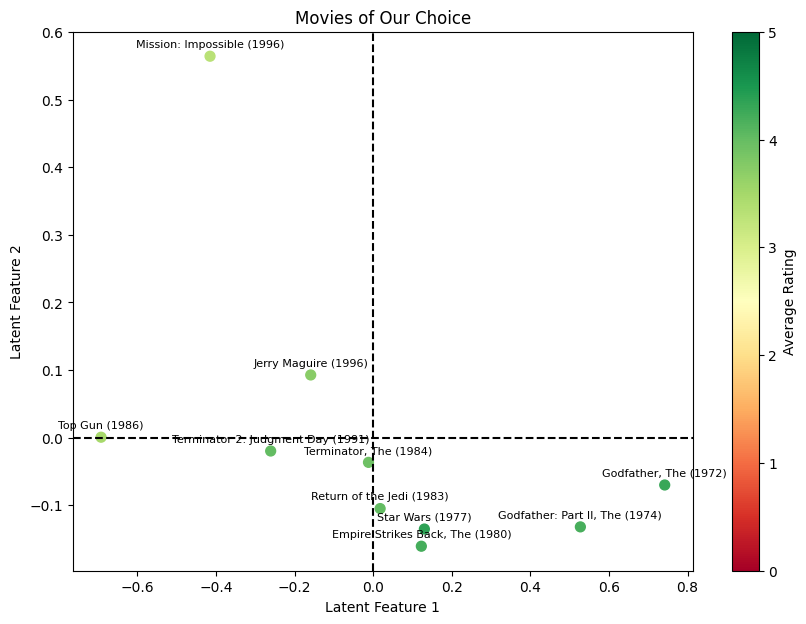

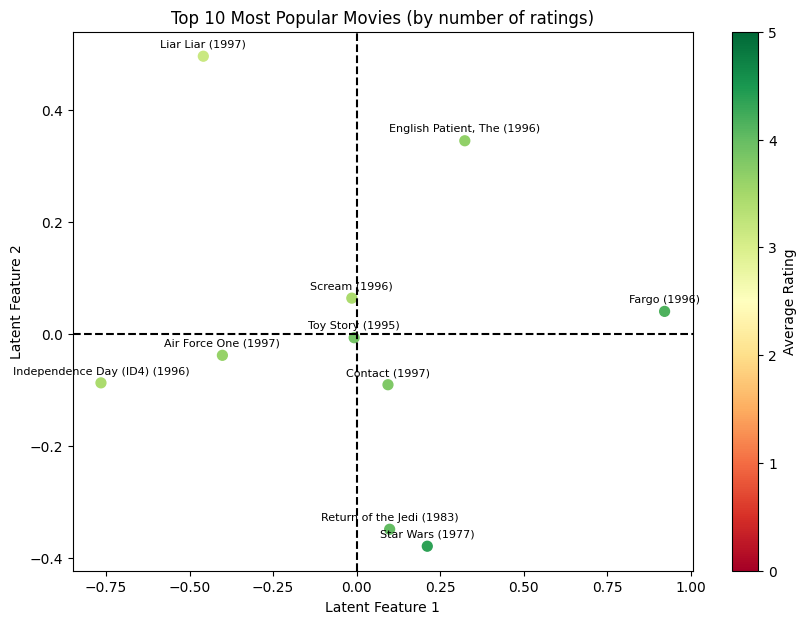

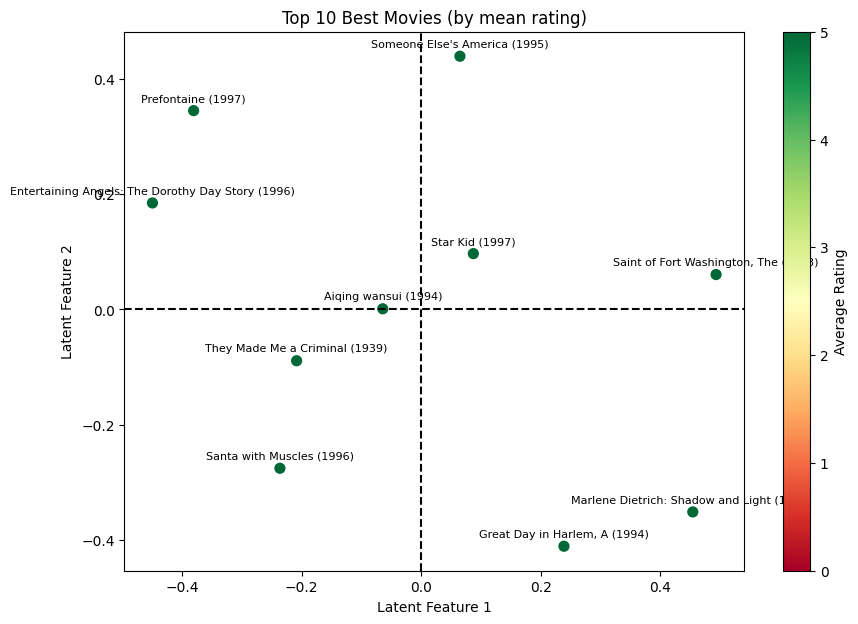

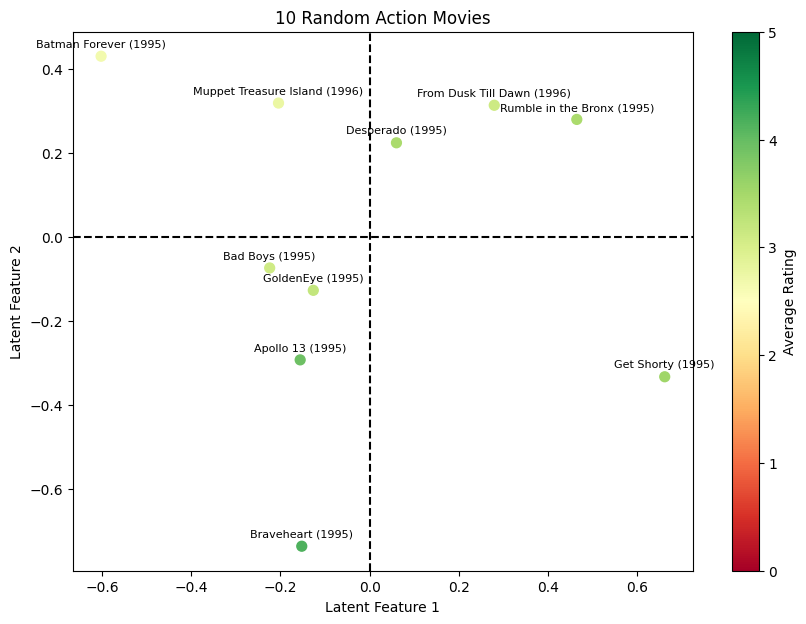

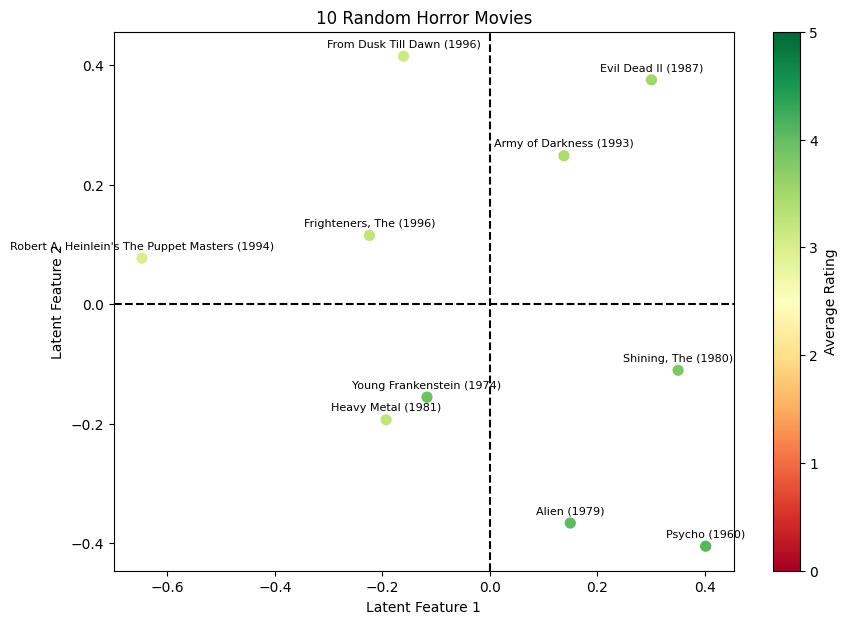

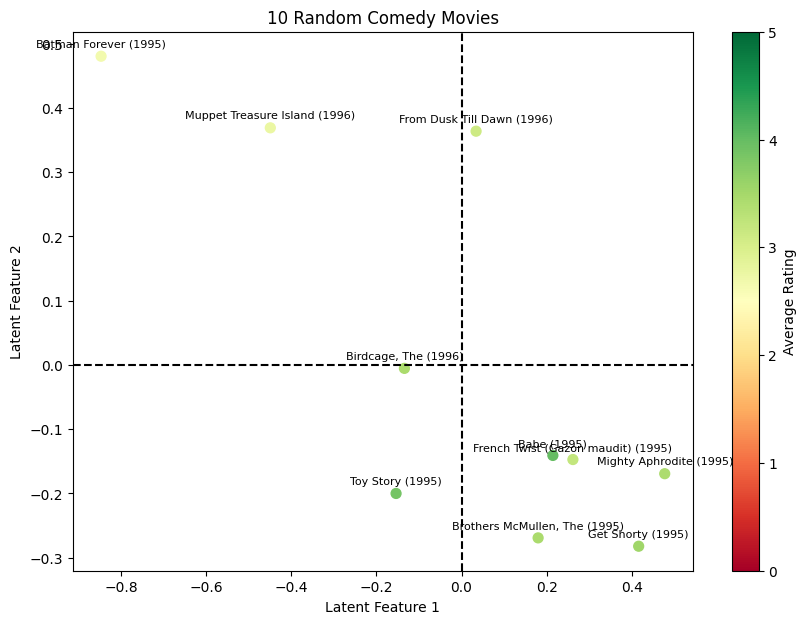

In [77]:
U_tilde, V_tilde = get_projections(U, V)
avg_ratings = np.array(data[['Movie ID', 'Rating']].groupby('Movie ID').mean().sort_values('Movie ID'))

chosen_ids = np.array([161, 405, 237, 127, 187, 96, 195, 50, 172, 181])
plot_visualizations(chosen_ids, 'Movies of Our Choice', V_tilde)

most_popular_ids = np.array(data['Movie ID'].value_counts().head(10).index)
plot_visualizations(most_popular_ids, 'Top 10 Most Popular Movies (by number of ratings)', V_tilde)

best_ids = np.array(data[['Movie ID', 'Rating']].groupby('Movie ID').mean().sort_values('Rating', ascending=False).head(10).index)
plot_visualizations(best_ids, 'Top 10 Best Movies (by mean rating)', V_tilde)

action_ids = np.array(movies[movies['Action']==1]['Movie ID'])
plot_visualizations(np.random.choice(action_ids[:10], size=10, replace=False), '10 Random Action Movies', V_tilde)

horror_ids = np.array(movies[movies['Horror']==1]['Movie ID'])
plot_visualizations(np.random.choice(horror_ids[:10], size=10, replace=False), '10 Random Horror Movies', V_tilde)

comedy_ids = np.array(movies[movies['Comedy']==1]['Movie ID'])
plot_visualizations(np.random.choice(comedy_ids[:10], size=10, replace=False), '10 Random Comedy Movies', V_tilde)

# Now for the third method, the off the shelf implementation

In [45]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163008 sha256=2d33af9b2e63892dc5501c3fcc6d9c27b4b9b5819589c474ddbf6bc941c75cf0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [46]:
from surprise import Dataset, Reader
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import numpy as np

In [78]:
reader = Reader()
trainset = Dataset.load_from_df(train, reader)
trainset = trainset.build_full_trainset()
testset = [test.loc[i].to_list() for i in range(len(test))]

model = SVD(n_epochs=300, n_factors=20, lr_all=0.05, reg_all=0.1, biased=False)
model.fit(trainset)

predictions = model.test(testset)
accuracy.mse(predictions)

MSE: 0.9638


0.9637920673493334

In [79]:
U = model.pu
V = model.qi

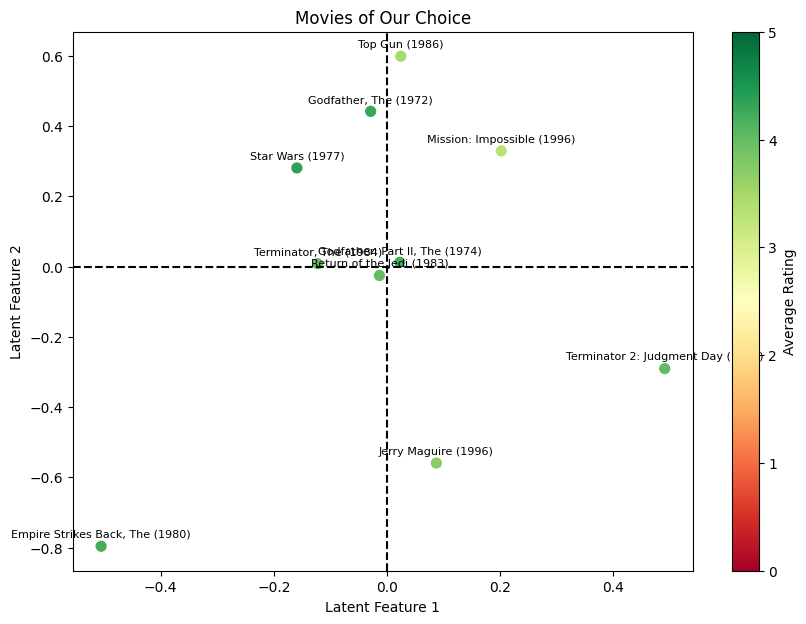

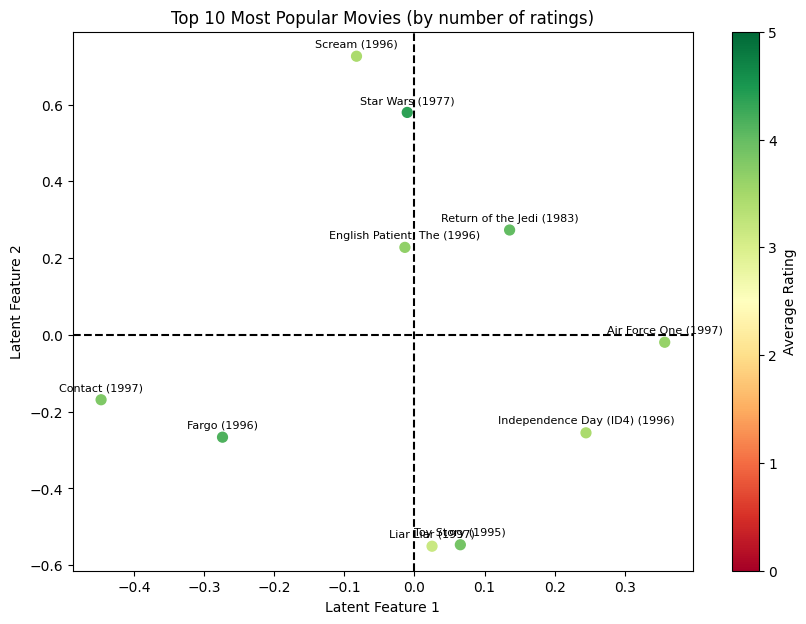

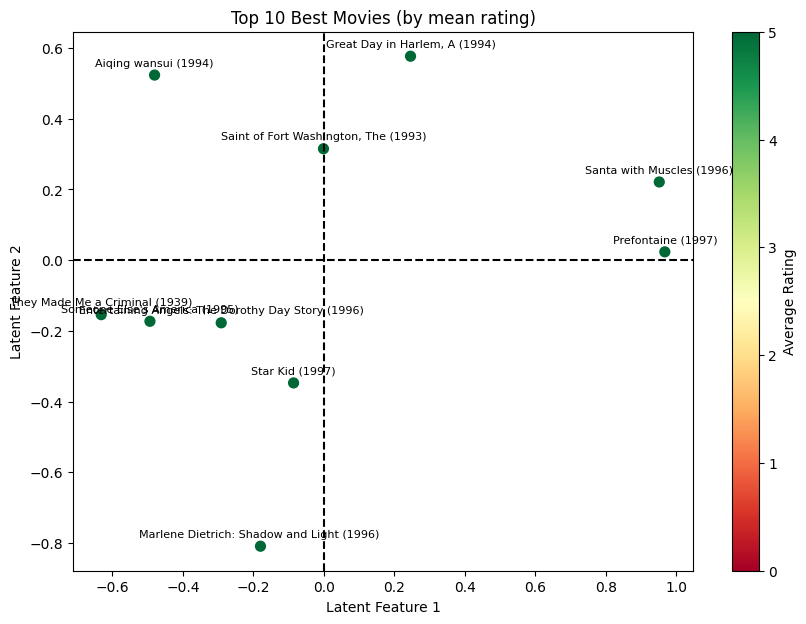

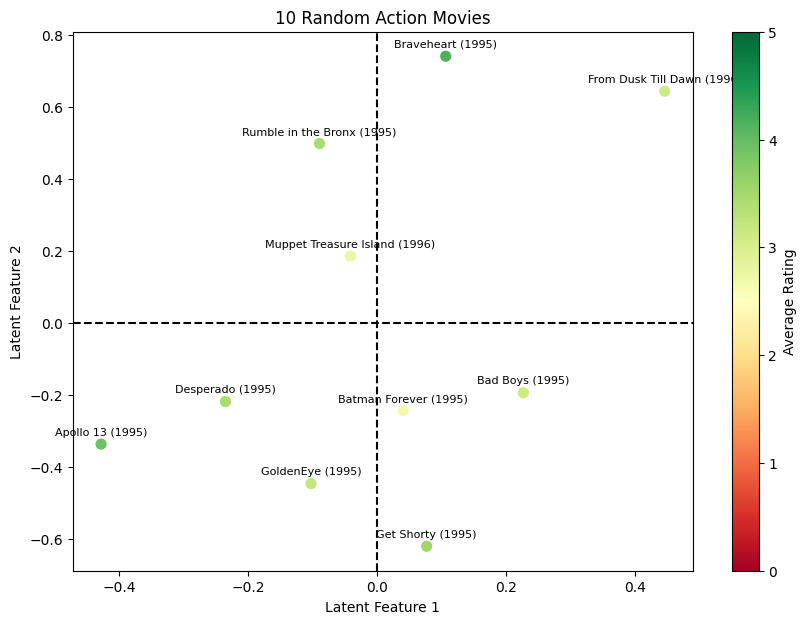

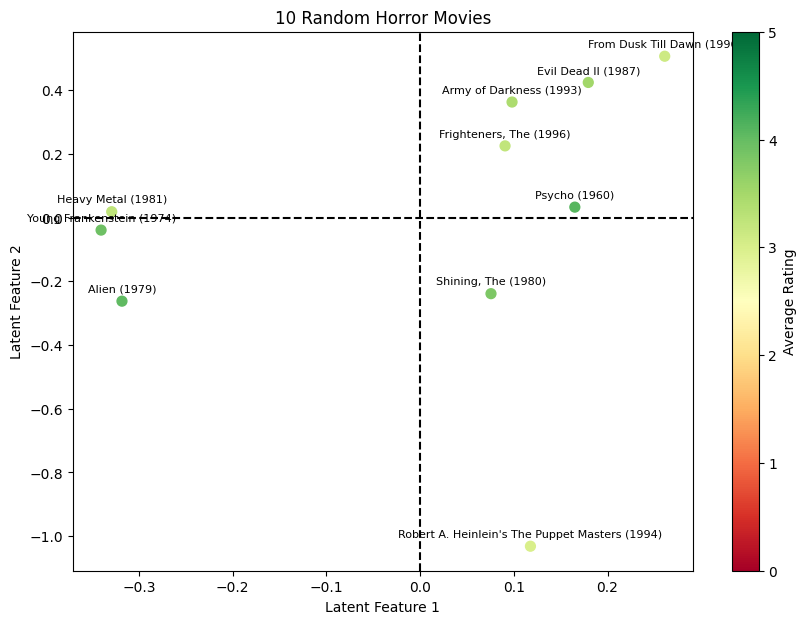

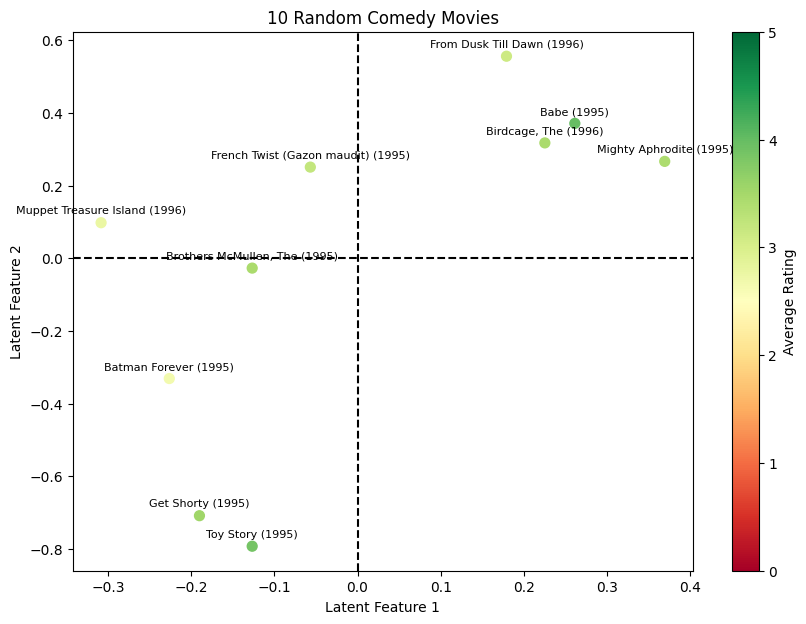

In [80]:
U_tilde, V_tilde = get_projections(U, V)
avg_ratings = np.array(data[['Movie ID', 'Rating']].groupby('Movie ID').mean().sort_values('Movie ID'))

chosen_ids = np.array([161, 405, 237, 127, 187, 96, 195, 50, 172, 181])
plot_visualizations(chosen_ids, 'Movies of Our Choice', V_tilde)

most_popular_ids = np.array(data['Movie ID'].value_counts().head(10).index)
plot_visualizations(most_popular_ids, 'Top 10 Most Popular Movies (by number of ratings)', V_tilde)

best_ids = np.array(data[['Movie ID', 'Rating']].groupby('Movie ID').mean().sort_values('Rating', ascending=False).head(10).index)
plot_visualizations(best_ids, 'Top 10 Best Movies (by mean rating)', V_tilde)

action_ids = np.array(movies[movies['Action']==1]['Movie ID'])
plot_visualizations(np.random.choice(action_ids[:10], size=10, replace=False), '10 Random Action Movies', V_tilde)

horror_ids = np.array(movies[movies['Horror']==1]['Movie ID'])
plot_visualizations(np.random.choice(horror_ids[:10], size=10, replace=False), '10 Random Horror Movies', V_tilde)

comedy_ids = np.array(movies[movies['Comedy']==1]['Movie ID'])
plot_visualizations(np.random.choice(comedy_ids[:10], size=10, replace=False), '10 Random Comedy Movies', V_tilde)